In [18]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import corneto as cn
from util import set_default_style, get_git_commit_hash

get_git_commit_hash("corneto")

'Current commit hash for corneto: 775d48b90b8ccb509db31707b5822fec64bbf47a'

In [19]:
set_default_style()

In [20]:
G = cn.Graph.from_miom_model("https://github.com/pablormier/miom-gems/raw/refs/heads/main/gems/mitocore/v1.0.1/default.miom")
G.shape

(441, 555)

In [21]:
df_experiments = pd.read_csv("experiments.csv", index_col=0)
df_experiments

,size,rep,intv_ids
0,2,0,[171 483]
1,2,1,[485 109]
2,2,2,[ 81 485]
3,2,3,[482 82]
4,2,4,[81 97]
5,2,5,[440 108]
6,2,6,[535 74]
7,2,7,[170 535]
8,2,8,[483 440]
9,2,9,[ 35 486]


In [22]:
with open("results_90.pkl", "rb") as file:
    results_90 = pickle.load(file)

with open("results_50.pkl", "rb") as file:
    results_50 = pickle.load(file)
    
with open("results_10.pkl", "rb") as file:
    results_10 = pickle.load(file)

In [23]:
def get_df_results(df_experiments, results):
    r_values = []
    for (i, r), res in zip(df_experiments.iterrows(), results):
        r_values.append((r["size"], r.rep, res[-1], res[-2]))
    df = pd.DataFrame(r_values, columns=['size_interv', 'rep', 'multi', 'single'])
    return df

def boxplots(df, ax=None, palette=None, despine=False):
    df_long = df.drop('rep', axis=1).melt(id_vars='size_interv', var_name='method', value_name='value')
    g = sns.boxplot(x="size_interv", y="value", hue="method", palette=palette, data=df_long, ax=ax)
    g.set_xlabel("Number of conditions\n(condition = single KO on an enzyme)")
    g.set_ylabel("N. of unique reactions")
    if despine:
        sns.despine()
    return g

def calc_props(results):
    selected_single = []
    selected_multi = []
    for r in results:
        _, result_single, _, result_multi, _, _, _ = r
        selected_multi.append(result_multi)
        selected_single.append(result_single)
    prop_rxn_single = np.concatenate(selected_single, axis=1).mean(axis=1)
    prop_rxn_multi = np.concatenate(selected_multi, axis=1).mean(axis=1)
    df_proportions = pd.DataFrame(
        {'rxn': G.get_attr_from_edges("id"), 'rxn_prop_single': prop_rxn_single, 'rxn_prop_multi': prop_rxn_multi}
    ).set_index("rxn").sort_values(by="rxn_prop_multi", ascending=False)
    return df_proportions

def plot_rxn_proportions(df_proportions, n=50, ax=None, despine=False, horizontal=False, ascending=False):
    ix_rxn = df_proportions.std(axis=1).sort_values(ascending=False).head(n).index
    df_top_proportions = df_proportions.loc[ix_rxn].sort_values(by="rxn_prop_multi", ascending=ascending)
    df_top_proportions.columns=['single', 'multi']
    df_top_proportions = df_top_proportions[["multi", "single"]]
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        created_fig = True
    if horizontal:
        df_top_proportions.plot(kind='barh', stacked=False, ax=ax)
    else:
        df_top_proportions.plot(kind='bar', stacked=False, ax=ax)
    ax.set_xlabel('Reactions')
    ax.set_ylabel('Prop. of reactions')

    # Customizing x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90) # Rotate labels to vertical
    ax.tick_params(axis='x', labelsize=10) # Make labels smaller

    if despine:
        sns.despine()

    # Apply tight_layout if a new figure was created
    if created_fig:
        fig.tight_layout()


    return ax

def collect(experiments, results, fluxes=False):
    nets = []
    labels = []
    for (i, r), res in zip(experiments.iterrows(), results):
        sz = r['size']
        if not fluxes:
            N_single = res[1].astype(int)
            N_multi = res[3].astype(int)
        else:
            N_single = res[2]
            N_multi = res[4]
        nets.append(N_single)
        labels.extend([f"c{sz}_single"]*N_single.shape[1])
        nets.append(N_multi)
        labels.extend([f"c{sz}_multi"]*N_multi.shape[1])

    cnets = np.concatenate(nets, axis=1)
    return pd.DataFrame(cnets, index=net.R['id'], columns=labels)

def create_multifig(df_experiments, result, prop=1.0, n_top_rxn_prop=25, figsize=(20, 6), title=True, fontsize=20, axs=None):
    fig = None
    if axs is None:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    g = boxplots(get_df_results(df_experiments, result), ax=axs[0])
    df_proportions = calc_props(result)
    plot_rxn_proportions(df_proportions, ax=axs[1], n=n_top_rxn_prop);
    if title:
        axs[0].set_title(f"A) Size of inferred network\n (multi vs union of single sFBA) (flux opt. {round(prop_opt_ko*100)}%)", pad=20, fontsize=fontsize);
        axs[1].set_title("B) Proportion of selected reactions across conditions", pad=20, fontsize=fontsize)
    return fig, axs


In [24]:
len(results_10)

40

In [25]:
get_df_results(df_experiments, results_10)

,size_interv,rep,multi,single
0,2,0,47,52
1,2,1,56,80
2,2,2,44,65
3,2,3,56,80
4,2,4,61,65
5,2,5,74,80
6,2,6,50,67
7,2,7,46,86
8,2,8,76,80
9,2,9,35,51


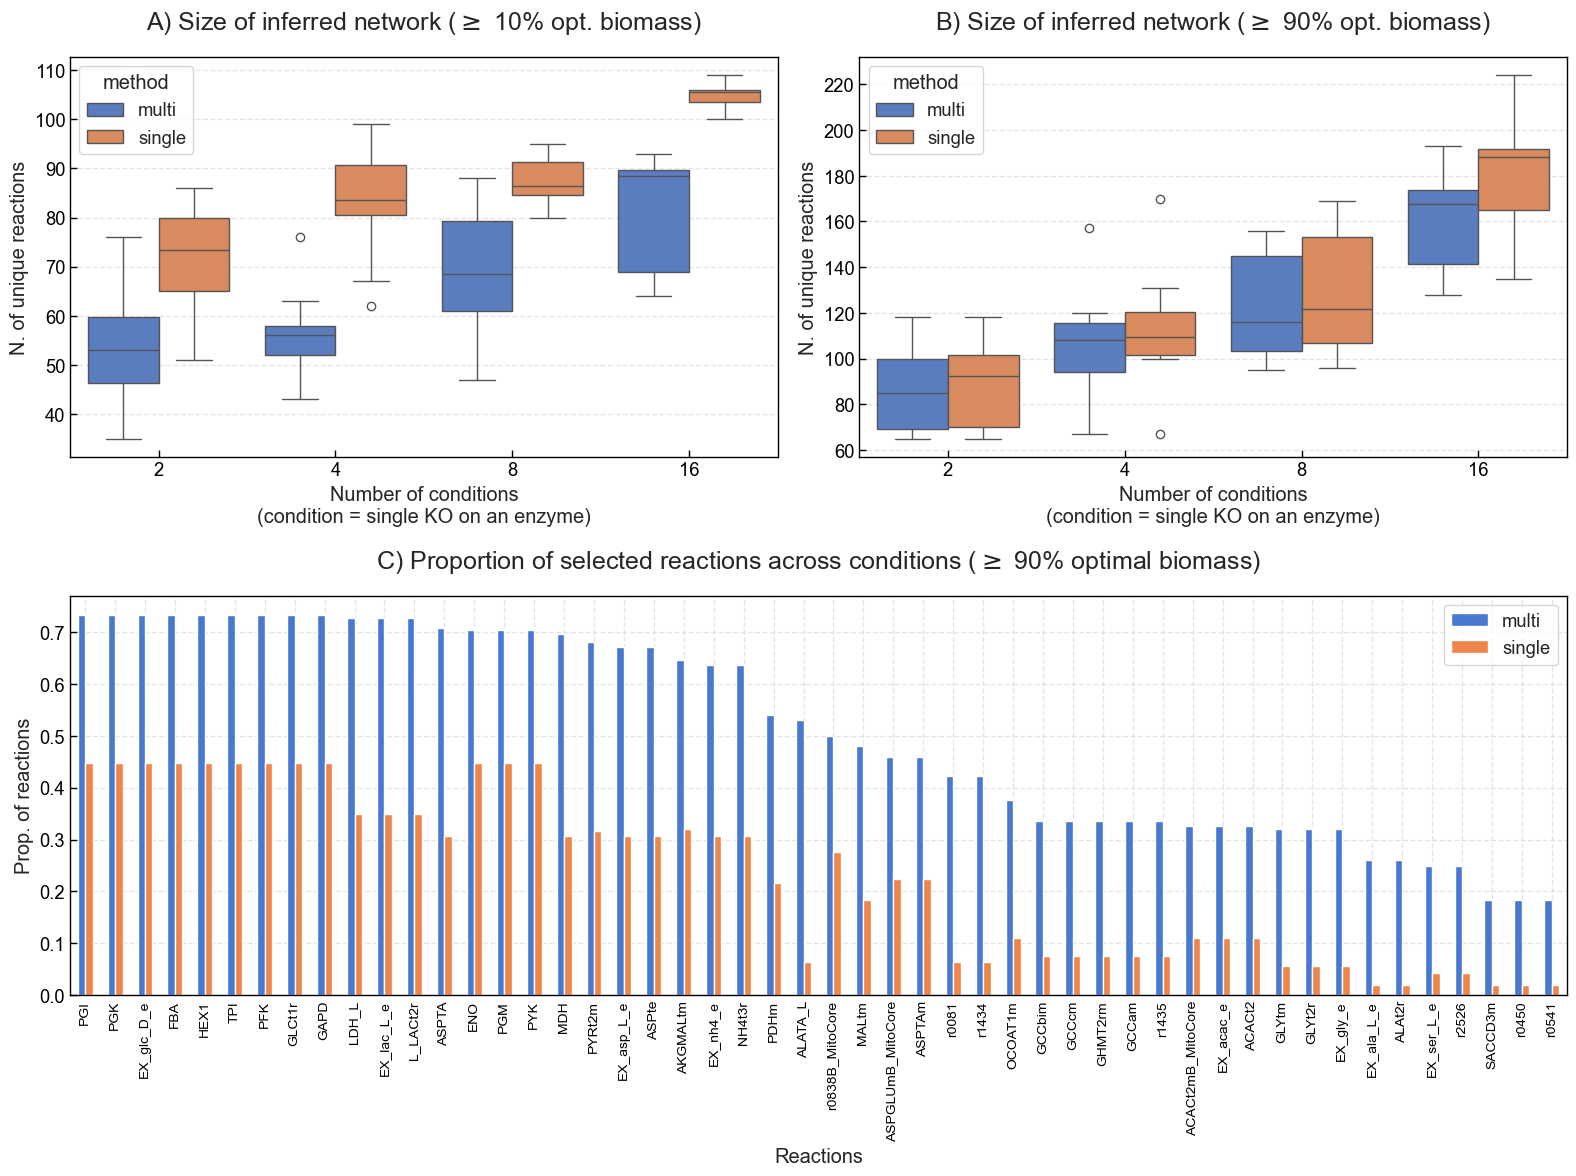

In [26]:
title_size = 18
title_pad = 20

plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((2, 2), (0, 0))
boxplots(get_df_results(df_experiments, results_10), ax=ax1)

# Add second subplot in first row, second column
ax2 = plt.subplot2grid((2, 2), (0, 1))
boxplots(get_df_results(df_experiments, results_90), ax=ax2)

# Add third subplot in second row spanning across both columns
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
plot_rxn_proportions(calc_props(results_90), ax=ax3, n=50);

ax1.set_title("A) Size of inferred network ($\geq$ 10% opt. biomass)", fontsize=title_size, pad=title_pad)
ax2.set_title("B) Size of inferred network ($\geq$ 90% opt. biomass)", fontsize=title_size, pad=title_pad)
ax3.set_title("C) Proportion of selected reactions across conditions ($\geq$ 90% optimal biomass)", fontsize=title_size, pad=title_pad)

# Show the plot
plt.tight_layout()
plt.savefig("figures/single_multi_sfba.pdf", format="pdf")

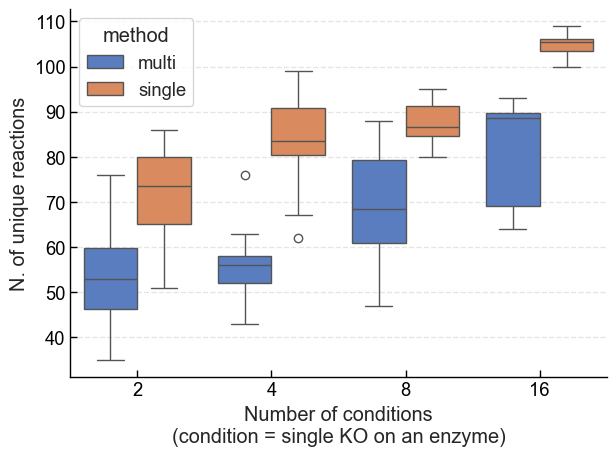

In [27]:
boxplots(get_df_results(df_experiments, results_10), despine=True)
plt.tight_layout()

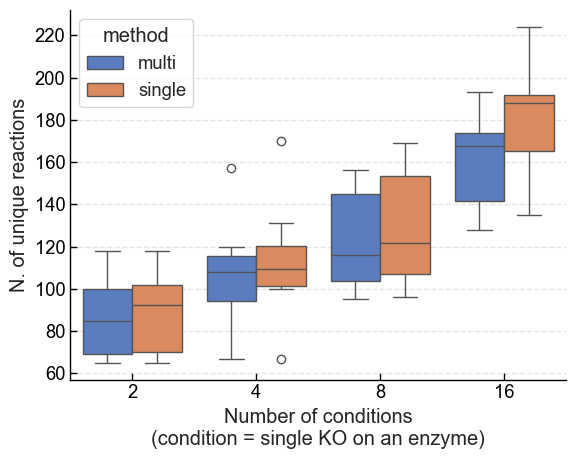

In [28]:
boxplots(get_df_results(df_experiments, results_90), despine=True);

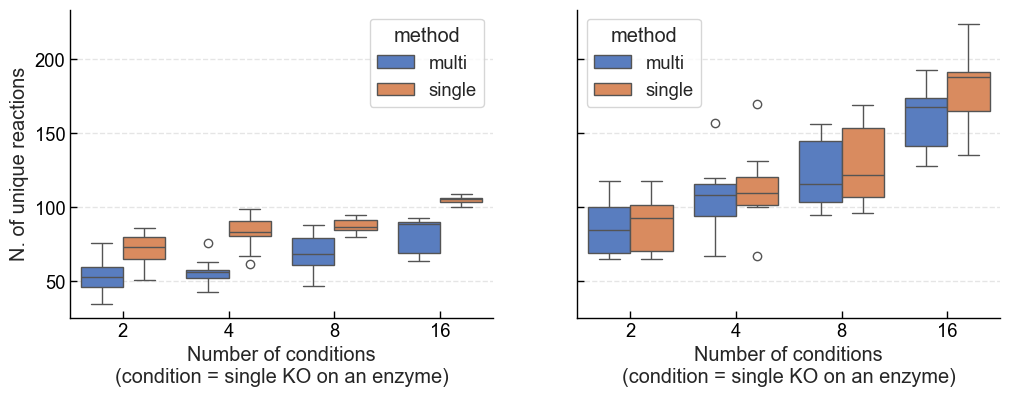

In [29]:
# Function to redraw and save an axis's plot
def draw_and_save(df, filename, original_ax, figsize=(6,4)):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Redraw the plot using the same data and styling
    boxplots(df, ax=ax)
    
    # Reapply any additional settings from the original axis
    ax.set_xlim(original_ax.get_xlim())
    ax.set_ylim(original_ax.get_ylim())
    ax.set_xlabel(original_ax.get_xlabel())
    ax.set_ylabel(original_ax.get_ylabel())
    ax.set_title(original_ax.get_title())

    # Save the figure
    fig.savefig(filename)
    plt.close(fig)  # Close the figure to free up memory


# Original plotting code
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
boxplots(get_df_results(df_experiments, results_10), ax=ax[0], despine=True)
boxplots(get_df_results(df_experiments, results_90), ax=ax[1], despine=True)


# Redraw and save each plot
draw_and_save(get_df_results(df_experiments, results_10), 'figures/results_10.pdf', ax[0])
draw_and_save(get_df_results(df_experiments, results_90), 'figures/results_90.pdf', ax[1])


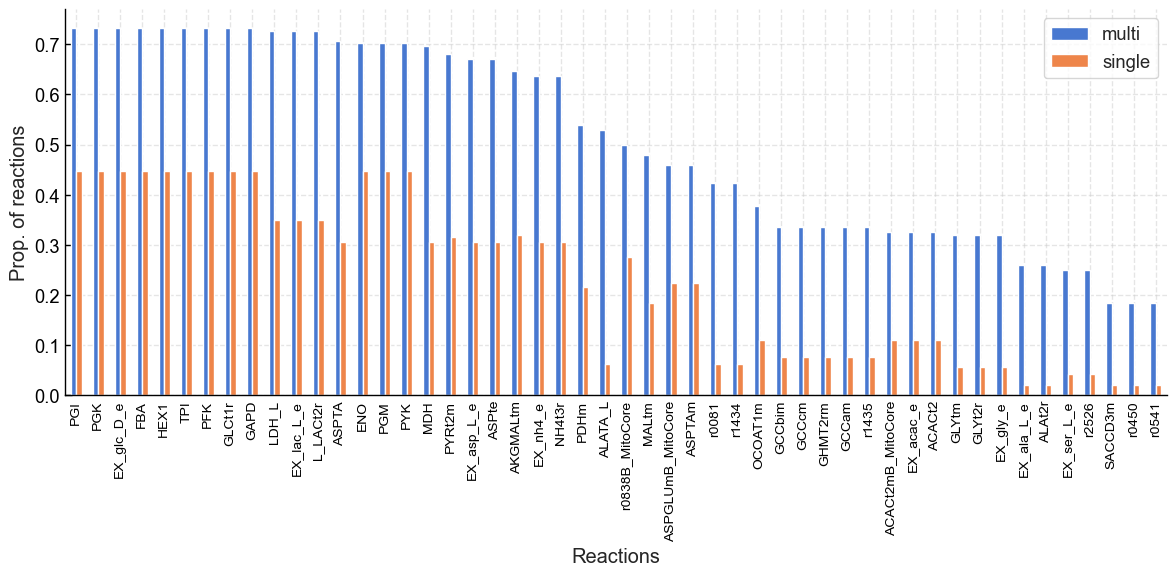

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_rxn_proportions(calc_props(results_90), ax=ax, n=50, despine=True);
fig.tight_layout()
fig.savefig("figures/prop_90perc.pdf")

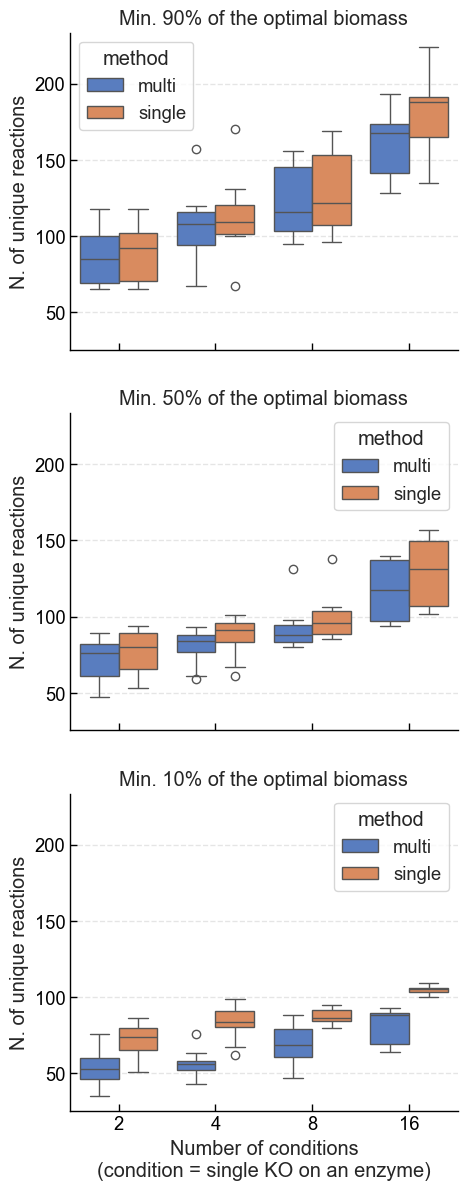

In [31]:
fig, ax = plt.subplots(3, 1, figsize=(5, 14), sharey=True, sharex=True)
boxplots(get_df_results(df_experiments, results_10), ax=ax[2], despine=True)
boxplots(get_df_results(df_experiments, results_50), ax=ax[1], despine=True)
boxplots(get_df_results(df_experiments, results_90), ax=ax[0], despine=True)
ax[0].set_title("Min. 90% of the optimal biomass")
ax[1].set_title("Min. 50% of the optimal biomass")
ax[2].set_title("Min. 10% of the optimal biomass")

plt.savefig("figures/vertical_boxplots.pdf")
# Redraw and save each plot
#draw_and_save(get_df_results(df_experiments, results_10), 'figures/results_10.pdf', ax[0])
#draw_and_save(get_df_results(df_experiments, results_90), 'figures/results_90.pdf', ax[1])

/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/ipykernel_2868/4039036809.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90) # Rotate labels to vertical


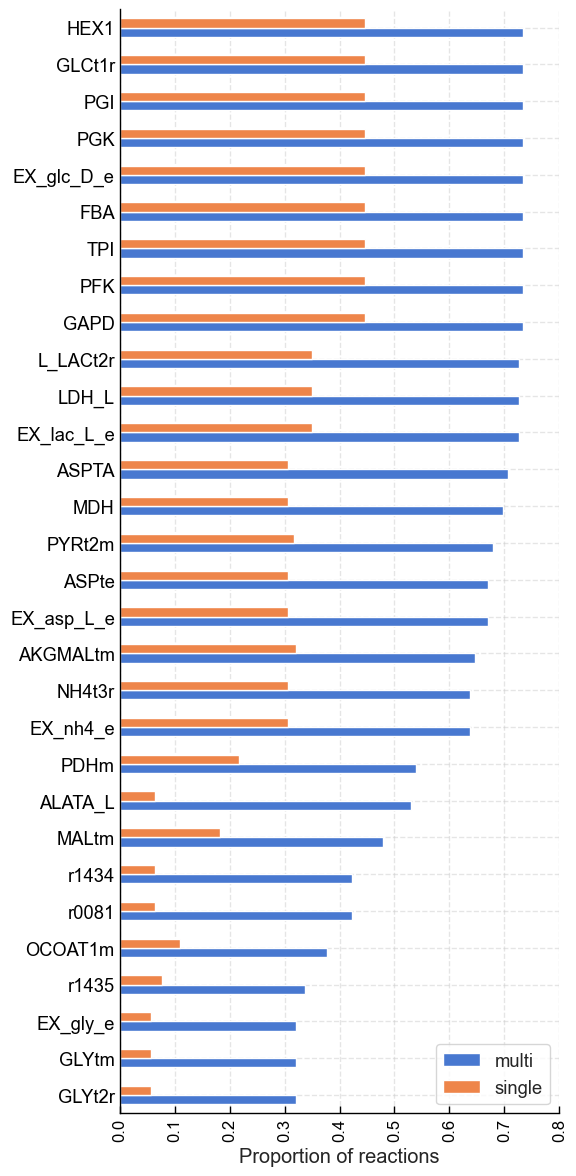

In [32]:
fig, ax = plt.subplots(figsize=(6, 12))
plot_rxn_proportions(calc_props(results_90), ax=ax, n=30, despine=True, horizontal=True, ascending=True);
plt.xlabel("Proportion of reactions")
plt.ylabel("")
# Fix labels
locs, labels = plt.xticks()
new_labels = np.linspace(0, max([float(l.get_text()) for l in labels if l.get_text() != '']), len(locs))
plt.xticks(locs, [f"{v:.1f}" for v in new_labels], fontsize=12)
fig.tight_layout()
fig.savefig("figures/prop_90perc_h.pdf")

In [40]:
def reduction(results):
    reductions = []
    for r in results:
        M = r[-1]
        S = r[-2]
        reduction = ((S-M)/S)*100
        reductions.append(reduction)
    return np.median(reductions)

reduction(results_90), reduction(results_50), reduction(results_10)

(np.float64(6.027596223674655),
 np.float64(7.211851026284016),
 np.float64(30.0))

In [42]:
len(results_10)

40